# BOOTCAMP DATASCIENCE

## Projekt Zaliczeniowy

## Prognoza otrzymania pożyczki na podstawie podanych danych we wniosku

#### IN:

- ID - Unique ID (can not be used for predictions)
- Gender- Sex
- City - Current City
- Monthly_Income - Monthly Income in rupees
- DOB - Date of Birth
- Lead_Creation_Date - Lead Created on date
- Loan_Amount_Applied - Loan Amount Requested (INR)
- Loan_Tenure_Applied - Loan Tenure Requested (in years)
- Existing_EMI - EMI of Existing Loans (INR)
- Employer_Name - Employer Name
- Salary_Account- Salary account with Bank
- Mobile_Verified - Mobile Verified (Y/N)
- Var5- Continuous classified variable
- Var1- Categorical variable with multiple levels
- Loan_Amount_Submitted- Loan Amount Revised and Selected after seeing Eligibility
- Loan_Tenure_Submitted- Loan Tenure Revised and Selected after seeing Eligibility (Years)
- Interest_Rate- Interest Rate of Submitted Loan Amount
- Processing_Fee- Processing Fee of Submitted Loan Amount (INR)
- EMI_Loan_Submitted- EMI of Submitted Loan Amount (INR)
- Filled_Form- Filled Application form post quote
- Device_Type- Device from which application was made (Browser/ Mobile)
- Var2- Categorical Variable with multiple Levels
- Source- Categorical Variable with multiple Levels
- Var4- Categorical Variable with multiple Levels

#### OUT:

- LoggedIn- Application Logged (Variable for understanding the problem – cannot be used in prediction)
- Disbursed- Loan Disbursed (Target Variable)

### Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import pprint
import xgboost as xgb
import matplotlib.pyplot as plt
import math

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from datetime import datetime

np.random.seed(42)

### Sprawdzenie dostępnych plików w systemie  WINDOWS

In [2]:
!dir /b

.ipynb_checkpoints
main.ipynb
Train.csv


### Import danych

In [3]:
data = pd.read_csv('Train.csv', encoding = "ISO-8859-1")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 26 columns):
ID                       87020 non-null object
Gender                   87020 non-null object
City                     86017 non-null object
Monthly_Income           87020 non-null int64
DOB                      87020 non-null object
Lead_Creation_Date       87020 non-null object
Loan_Amount_Applied      86949 non-null float64
Loan_Tenure_Applied      86949 non-null float64
Existing_EMI             86949 non-null float64
Employer_Name            86949 non-null object
Salary_Account           75256 non-null object
Mobile_Verified          87020 non-null object
Var5                     87020 non-null int64
Var1                     87020 non-null object
Loan_Amount_Submitted    52407 non-null float64
Loan_Tenure_Submitted    52407 non-null float64
Interest_Rate            27726 non-null float64
Processing_Fee           27420 non-null float64
EMI_Loan_Submitted       27726 non-null 

Na podstawie powyższych informacji - kolumny do usunięcia ze względu na małą ilość danych:
- 'Loan_Amount_Submitted',
- 'Loan_Tenure_Submitted',
- 'Interest_Rate',
- 'Processing_Fee',
- 'EMI_Loan_Submitted'

In [5]:
columns_to_del = ['Loan_Amount_Submitted','Loan_Tenure_Submitted','Interest_Rate',
                  'Processing_Fee','EMI_Loan_Submitted','LoggedIn']

### Przepisanie danych do osobnego DataFrame

In [6]:
data_new = data.copy()

In [7]:
data_new.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,NaN,NaN,N,Web-browser,B,S134,3,1,0


### Wyliczenie sensownego wieku (w dniach) na podstawie daty urodzenia i daty złożenia wniosku
#### Correcting Date of birth

In [8]:
data_new['DOB_new'] = ['-'.join([item.split('-')[0],item.split('-')[1],'19' + item.split('-')[2]]) for item in data['DOB']]

In [9]:
data_new['DOB_new'] = pd.to_datetime(data_new['DOB_new'])

#### Correcting Lead Creation Date

In [10]:
data_new['Lead_Creation_Date_new'] = pd.to_datetime(data_new['Lead_Creation_Date'])

#### Creating Age in Days when lead was created

In [11]:
data_new['Age_In_Days'] = (data_new['Lead_Creation_Date_new']-data_new['DOB_new']).astype('timedelta64[D]')

### Usunięcie niepotrzebnych kolumn i kolumn tymczasowych

In [12]:
data_new = data_new.drop(['ID','DOB','Lead_Creation_Date','DOB_new','Lead_Creation_Date_new'], axis=1)

In [13]:
data_new = data_new.drop(columns_to_del, axis=1)

In [14]:
data_new.columns

Index(['Gender', 'City', 'Monthly_Income', 'Loan_Amount_Applied',
       'Loan_Tenure_Applied', 'Existing_EMI', 'Employer_Name',
       'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1', 'Filled_Form',
       'Device_Type', 'Var2', 'Source', 'Var4', 'Disbursed', 'Age_In_Days'],
      dtype='object')

### Czyszczenie danych - przygotowanie pod modelowanie

In [15]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 18 columns):
Gender                 87020 non-null object
City                   86017 non-null object
Monthly_Income         87020 non-null int64
Loan_Amount_Applied    86949 non-null float64
Loan_Tenure_Applied    86949 non-null float64
Existing_EMI           86949 non-null float64
Employer_Name          86949 non-null object
Salary_Account         75256 non-null object
Mobile_Verified        87020 non-null object
Var5                   87020 non-null int64
Var1                   87020 non-null object
Filled_Form            87020 non-null object
Device_Type            87020 non-null object
Var2                   87020 non-null object
Source                 87020 non-null object
Var4                   87020 non-null int64
Disbursed              87020 non-null int64
Age_In_Days            87020 non-null float64
dtypes: float64(4), int64(4), object(10)
memory usage: 12.0+ MB


In [16]:
null_search = data_new.isnull().sum()
null_search

Gender                     0
City                    1003
Monthly_Income             0
Loan_Amount_Applied       71
Loan_Tenure_Applied       71
Existing_EMI              71
Employer_Name             71
Salary_Account         11764
Mobile_Verified            0
Var5                       0
Var1                       0
Filled_Form                0
Device_Type                0
Var2                       0
Source                     0
Var4                       0
Disbursed                  0
Age_In_Days                0
dtype: int64

#### Zgrupowanie mało istotnych wartości dla poszczególnych kolumn oraz uzupełnienie pustych wartości 
Wszystkie wartości pojawiające się mniej niż 1% w całej próbce zmieniamy na OTHER

In [17]:
OTHER_TRESHOLD = 1

#### Kolumna: VAR1

In [18]:
data_new['Var1'].unique()

array(['HBXX', 'HBXA', 'HAXM', 'HAXB', 'HBXC', 'HBXD', 'HBXH', 'HAXA',
       'HBXB', 'HAYT', 'HCXD', 'HVYS', 'HAVC', 'HCXG', 'HAZD', 'HCYS',
       'HCXF', 'HAXC', 'HAXF'], dtype=object)

In [19]:
suma = 0
for _, item in enumerate(data_new.Var1.value_counts()):
    suma += item / data_new.shape[0]
    print(_, ':::', data_new.Var1.value_counts().index[_], ':::' , item, ':::',100 * (item / data_new.shape[0]) , ' ::: ' ,str(suma*100))

0 ::: HBXX ::: 59294 ::: 68.13835899793152  :::  68.13835899793152
1 ::: HBXC ::: 9010 ::: 10.35394162261549  :::  78.49230062054701
2 ::: HBXB ::: 4479 ::: 5.147092622385658  :::  83.63939324293267
3 ::: HAXA ::: 2909 ::: 3.3429096759365664  :::  86.98230291886924
4 ::: HBXA ::: 2123 ::: 2.4396690415996325  :::  89.42197196046887
5 ::: HAXB ::: 2011 ::: 2.310962997012181  :::  91.73293495748105
6 ::: HBXD ::: 1964 ::: 2.2569524247299473  :::  93.989887382211
7 ::: HAXC ::: 1536 ::: 1.7651114686279015  :::  95.7549988508389
8 ::: HBXH ::: 970 ::: 1.1146862790163181  :::  96.86968512985523
9 ::: HCXF ::: 722 ::: 0.8296943231441047  :::  97.69937945299932
10 ::: HAYT ::: 508 ::: 0.5837738450930821  :::  98.2831532980924
11 ::: HAVC ::: 384 ::: 0.44127786715697537  :::  98.72443116524938
12 ::: HAXM ::: 268 ::: 0.30797517811997244  :::  99.03240634336935
13 ::: HCXD ::: 237 ::: 0.27235118363594574  :::  99.3047575270053
14 ::: HCYS ::: 217 ::: 0.24936796138818662  :::  99.55412548839348
1

In [20]:
map_var1 = dict()
for _, item in enumerate(data_new.Var1.value_counts()):
    if 100 * (item / data_new.shape[0]) < OTHER_TRESHOLD:
        key = data_new.Var1.value_counts().index[_]
        map_var1[key] = 'OTHER'

In [21]:
data_new.Var1.replace(to_replace=map_var1, inplace=True)

In [22]:
suma = 0
for _, item in enumerate(data_new.Var1.value_counts()):
    suma += item / data_new.shape[0]
    print(_, ':::', data_new.Var1.value_counts().index[_], ':::' , item, ':::',100 * (item / data_new.shape[0]) , ' ::: ' ,str(suma*100))

0 ::: HBXX ::: 59294 ::: 68.13835899793152  :::  68.13835899793152
1 ::: HBXC ::: 9010 ::: 10.35394162261549  :::  78.49230062054701
2 ::: HBXB ::: 4479 ::: 5.147092622385658  :::  83.63939324293267
3 ::: HAXA ::: 2909 ::: 3.3429096759365664  :::  86.98230291886924
4 ::: OTHER ::: 2724 ::: 3.1303148701447943  :::  90.11261778901402
5 ::: HBXA ::: 2123 ::: 2.4396690415996325  :::  92.55228683061367
6 ::: HAXB ::: 2011 ::: 2.310962997012181  :::  94.86324982762584
7 ::: HBXD ::: 1964 ::: 2.2569524247299473  :::  97.1202022523558
8 ::: HAXC ::: 1536 ::: 1.7651114686279015  :::  98.88531372098369
9 ::: HBXH ::: 970 ::: 1.1146862790163181  :::  100.0


#### Kolumna: VAR2

In [23]:
suma = 0
for _, item in enumerate(data_new.Var2.value_counts()):
    suma += item / data_new.shape[0]
    print(_, ':::', data_new.Var2.value_counts().index[_], ':::' , item, ':::',100 * (item / data_new.shape[0]) , ' ::: ' ,str(suma*100))

0 ::: B ::: 37280 ::: 42.84072626982303  :::  42.84072626982303
1 ::: G ::: 33032 ::: 37.95908986439899  :::  80.79981613422203
2 ::: C ::: 14210 ::: 16.329579407032867  :::  97.1293955412549
3 ::: E ::: 1315 ::: 1.5111468627901632  :::  98.64054240404505
4 ::: D ::: 634 ::: 0.7285681452539646  :::  99.36911054929901
5 ::: F ::: 544 ::: 0.6251436451390485  :::  99.99425419443806
6 ::: A ::: 5 ::: 0.005745805561939783  :::  100.0


In [24]:
map_var2 = dict()
for _, item in enumerate(data_new.Var2.value_counts()):
    if 100 * (item / data_new.shape[0]) < OTHER_TRESHOLD:
        key = data_new.Var2.value_counts().index[_]
        map_var2[key] = 'OTHER'

In [25]:
data_new.Var2.replace(to_replace=map_var2, inplace=True)

In [26]:
suma = 0
for _, item in enumerate(data_new.Var2.value_counts()):
    suma += item / data_new.shape[0]
    print(_, ':::', data_new.Var2.value_counts().index[_], ':::' , item, ':::',100 * (item / data_new.shape[0]) , ' ::: ' ,str(suma*100))

0 ::: B ::: 37280 ::: 42.84072626982303  :::  42.84072626982303
1 ::: G ::: 33032 ::: 37.95908986439899  :::  80.79981613422203
2 ::: C ::: 14210 ::: 16.329579407032867  :::  97.1293955412549
3 ::: E ::: 1315 ::: 1.5111468627901632  :::  98.64054240404505
4 ::: OTHER ::: 1183 ::: 1.3594575959549529  :::  100.0


#### Kolumna: SALARY_ACCOUNT

wyświetlenie ~20 najczęściej pojawiających się banków

In [27]:
suma = 0
for _, item in enumerate(data_new.Salary_Account.value_counts()):
    suma += item / data_new.shape[0]
    print(_, ':::', data_new.Salary_Account.value_counts().index[_], ':::' , item, ':::',100 * (item / data_new.shape[0]) , ' ::: ' ,str(suma*100))
    if _ > 20:
        break

0 ::: HDFC Bank ::: 17695 ::: 20.334405883704896  :::  20.334405883704896
1 ::: ICICI Bank ::: 13636 ::: 15.669960928522178  :::  36.004366812227076
2 ::: State Bank of India ::: 11843 ::: 13.609515054010574  :::  49.61388186623765
3 ::: Axis Bank ::: 8783 ::: 10.093082050103424  :::  59.706963916341074
4 ::: Citibank ::: 2376 ::: 2.7304068030337856  :::  62.437370719374854
5 ::: Kotak Bank ::: 2067 ::: 2.375316019305907  :::  64.81268673868075
6 ::: IDBI Bank ::: 1550 ::: 1.7811997242013329  :::  66.5938864628821
7 ::: Punjab National Bank ::: 1201 ::: 1.3801424959779363  :::  67.97402895886002
8 ::: Bank of India ::: 1170 ::: 1.3445185014939096  :::  69.31854746035393
9 ::: Bank of Baroda ::: 1126 ::: 1.2939554125488393  :::  70.61250287290277
10 ::: Standard Chartered Bank ::: 995 ::: 1.143415306826017  :::  71.75591817972878
11 ::: Canara Bank ::: 990 ::: 1.1376695012640774  :::  72.89358768099287
12 ::: Union Bank of India ::: 951 ::: 1.0928522178809468  :::  73.98643989887381
13 

In [28]:
map_salaryacc = dict()
for _, item in enumerate(data_new.Salary_Account.value_counts()):
    if 100 * (item / data_new.shape[0]) < OTHER_TRESHOLD:
        key = data_new.Salary_Account.value_counts().index[_]
        map_salaryacc[key] = 'OTHER'

In [29]:
data_new.Salary_Account.replace(to_replace=map_salaryacc, inplace=True)

##### Puste wartość w kolumnie Salary_Account 
Puste wartości mogą oznaczać, że klient otrzymuje wypłatę do ręki co może być istotne w modelowaniu, dlatego uzupełniamy wartością "None"

In [30]:
data_new['Salary_Account'].fillna('None',inplace=True)

In [31]:
suma = 0
for _, item in enumerate(data_new.Salary_Account.value_counts()):
    suma += item / data_new.shape[0]
    print(_, ':::', data_new.Salary_Account.value_counts().index[_], ':::' , item, ':::',100 * (item / data_new.shape[0]) , ' ::: ' ,str(suma*100))

0 ::: HDFC Bank ::: 17695 ::: 20.334405883704896  :::  20.334405883704896
1 ::: ICICI Bank ::: 13636 ::: 15.669960928522178  :::  36.004366812227076
2 ::: State Bank of India ::: 11843 ::: 13.609515054010574  :::  49.61388186623765
3 ::: None ::: 11764 ::: 13.518731326131924  :::  63.13261319236957
4 ::: OTHER ::: 10873 ::: 12.494828774994254  :::  75.62744196736382
5 ::: Axis Bank ::: 8783 ::: 10.093082050103424  :::  85.72052401746724
6 ::: Citibank ::: 2376 ::: 2.7304068030337856  :::  88.45093082050101
7 ::: Kotak Bank ::: 2067 ::: 2.375316019305907  :::  90.82624683980693
8 ::: IDBI Bank ::: 1550 ::: 1.7811997242013329  :::  92.60744656400826
9 ::: Punjab National Bank ::: 1201 ::: 1.3801424959779363  :::  93.98758905998619
10 ::: Bank of India ::: 1170 ::: 1.3445185014939096  :::  95.3321075614801
11 ::: Bank of Baroda ::: 1126 ::: 1.2939554125488393  :::  96.62606297402894
12 ::: Standard Chartered Bank ::: 995 ::: 1.143415306826017  :::  97.76947828085495
13 ::: Canara Bank :::

#### Kolumna: CITY

wyświetlenie ~20 najczęściej pojawiających się miast

In [32]:
suma = 0
for _, item in enumerate(data_new.City.value_counts()):
    suma += item / data_new.shape[0]
    print(_, ':::', data_new.City.value_counts().index[_], ':::' , item, ':::',100 * (item / data_new.shape[0]) , ' ::: ' ,str(suma*100))
    if _ > 20:
        break

0 ::: Delhi ::: 12527 ::: 14.395541254883934  :::  14.395541254883934
1 ::: Bengaluru ::: 10824 ::: 12.438519880487245  :::  26.83406113537118
2 ::: Mumbai ::: 10795 ::: 12.405194208227993  :::  39.23925534359917
3 ::: Hyderabad ::: 7272 ::: 8.356699609285222  :::  47.5959549528844
4 ::: Chennai ::: 6916 ::: 7.9475982532751095  :::  55.5435532061595
5 ::: Pune ::: 5207 ::: 5.983681912204091  :::  61.527235118363585
6 ::: Kolkata ::: 2888 ::: 3.318777292576419  :::  64.84601241094
7 ::: Ahmedabad ::: 1788 ::: 2.054700068949667  :::  66.90071247988968
8 ::: Jaipur ::: 1331 ::: 1.5295334405883705  :::  68.43024592047804
9 ::: Gurgaon ::: 1212 ::: 1.3927832682142036  :::  69.82302918869226
10 ::: Coimbatore ::: 1147 ::: 1.3180877959089863  :::  71.14111698460124
11 ::: Thane ::: 905 ::: 1.0399908067111008  :::  72.18110779131234
12 ::: Chandigarh ::: 870 ::: 0.9997701677775225  :::  73.18087795908987
13 ::: Surat ::: 802 ::: 0.9216272121351412  :::  74.102505171225
14 ::: Visakhapatnam :::

In [33]:
map_city = dict()
for _, item in enumerate(data_new.City.value_counts()):
    if 100 * (item / data_new.shape[0]) < OTHER_TRESHOLD:
        key = data_new.City.value_counts().index[_]
        map_city[key] = 'OTHER'

In [34]:
data_new.City.replace(to_replace=map_city, inplace=True)

##### Wypełnianie pustych wartości w polu City wpisem 'OTHER'

In [35]:
data_new['City'].fillna('OTHER',inplace=True)

In [36]:
data_new.City.value_counts()

OTHER         24208
Delhi         12527
Bengaluru     10824
Mumbai        10795
Hyderabad      7272
Chennai        6916
Pune           5207
Kolkata        2888
Ahmedabad      1788
Jaipur         1331
Gurgaon        1212
Coimbatore     1147
Thane           905
Name: City, dtype: int64

#### Kolumna: EMPLOYER NAME

In [37]:
data_new.Employer_Name.value_counts()

0                                               4914
TATA CONSULTANCY SERVICES LTD (TCS)              550
COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD     404
ACCENTURE SERVICES PVT LTD                       324
GOOGLE                                           301
HCL TECHNOLOGIES LTD                             250
ICICI BANK LTD                                   239
INDIAN AIR FORCE                                 191
INFOSYS TECHNOLOGIES                             181
GENPACT                                          179
IBM CORPORATION                                  173
INDIAN ARMY                                      171
TYPE SLOWLY FOR AUTO FILL                        162
WIPRO TECHNOLOGIES                               155
HDFC BANK LTD                                    148
IKYA HUMAN CAPITAL SOLUTIONS LTD                 142
STATE GOVERNMENT                                 134
INDIAN RAILWAY                                   130
INDIAN NAVY                                   

wyświetlenie ~30 najczęściej pojawiających się pracodawców

In [38]:
suma = 0
for _, item in enumerate(data_new.Employer_Name.value_counts()):
    suma += item / data_new.shape[0]
    print(_, ':::', data_new.Employer_Name.value_counts().index[_], ':::' , item, ':::',100 * (item / data_new.shape[0]) , ' ::: ' ,str(suma*100))
    if _ > 30:
        break

0 ::: 0 ::: 4914 ::: 5.64697770627442  :::  5.64697770627442
1 ::: TATA CONSULTANCY SERVICES LTD (TCS) ::: 550 ::: 0.6320386118133762  :::  6.2790163180877965
2 ::: COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD ::: 404 ::: 0.4642610894047346  :::  6.74327740749253
3 ::: ACCENTURE SERVICES PVT LTD ::: 324 ::: 0.37232820041369796  :::  7.115605607906228
4 ::: GOOGLE ::: 301 ::: 0.345897494828775  :::  7.461503102735002
5 ::: HCL TECHNOLOGIES LTD ::: 250 ::: 0.2872902780969892  :::  7.748793380831992
6 ::: ICICI BANK LTD ::: 239 ::: 0.2746495058607217  :::  8.023442886692713
7 ::: INDIAN AIR FORCE ::: 191 ::: 0.21948977246609974  :::  8.242932659158814
8 ::: INFOSYS TECHNOLOGIES ::: 181 ::: 0.20799816134222018  :::  8.450930820501034
9 ::: GENPACT ::: 179 ::: 0.20569983911744427  :::  8.656630659618477
10 ::: IBM CORPORATION ::: 173 ::: 0.19880487244311654  :::  8.855435532061593
11 ::: INDIAN ARMY ::: 171 ::: 0.19650655021834063  :::  9.051942082279934
12 ::: TYPE SLOWLY FOR AUTO FILL :::

##### Wypełnienie pustych wierszy w kolumnie wartością "0"

In [39]:
data_new['Employer_Name'].fillna('0',inplace=True)

##### Zamiana niewypełnionych i prawdopodobnie niewypełnionych wierszy przy wniosku oraz wypełnionych jako "OTHERS" na "OTHERS"

In [40]:
others_emp = ['TYPE SLOWLY FOR AUTO FILL', '0', 'OTHERS']

In [41]:
data_new.loc[data_new['Employer_Name'].isin(others_emp), 'Employer_Name'] = 'OTHERS'

##### Ujednolicenie popularnych nazw pracodawców (IBM, TATA)

In [42]:
data_new.loc[data_new['Employer_Name'].str.contains('IBM'), 'Employer_Name'] = 'IBM'

In [43]:
data_new.loc[data_new['Employer_Name'].str.contains('TATA'), 'Employer_Name'] = 'TATA CAPITAL GROUP'

##### Do dalszej analizy branie tylko 20 pracodawców, których pracownicy najczęściej otrzymują pożyczki
Czyli przygotowanie najistotniejszych pracodawców i tych mniej istotnych

In [44]:
emp_importance = data_new.groupby('Employer_Name')['Disbursed'].sum().sort_values(ascending=False)
emp_important = list(emp_importance[:20].index)

In [45]:
data_new.loc[ ~data_new['Employer_Name'].isin(emp_important), 'Employer_Name'] = 'Not Important Emp'

In [46]:
data_new.Employer_Name.value_counts()

Not Important Emp                                78022
OTHERS                                            5262
TATA CAPITAL GROUP                                1158
IBM                                                484
COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD       404
ACCENTURE SERVICES PVT LTD                         324
HCL TECHNOLOGIES LTD                               250
GENPACT                                            179
IKYA HUMAN CAPITAL SOLUTIONS LTD                   142
INDIAN RAILWAY                                     130
CAPGEMINI INDIA PVT LTD                             96
CIPLA LTD                                           90
HSBC ELECTRONIC DATA PROCESSING INDIA PVT LTD       78
KOTAK MAHINDRA BANK LTD                             76
TCS AND ASSOCIATES PVT LTD                          69
ERICSSON INDIA GLOBAL SERVICES PVT LTD              65
DR REDDYS LABORATORIES LTD                          58
BSNL                                                56
IDEA CELLU

#### Kolumna: SOURCE

In [47]:
data_new['Source'].unique()

array(['S122', 'S143', 'S134', 'S133', 'S159', 'S151', 'S137', 'S127',
       'S144', 'S123', 'S156', 'S153', 'S124', 'S161', 'S139', 'S154',
       'S157', 'S138', 'S162', 'S141', 'S158', 'S125', 'S129', 'S136',
       'S130', 'S155', 'S160', 'S150', 'S135', 'S140'], dtype=object)

In [48]:
suma = 0
for _, item in enumerate(data_new.Source.value_counts()):
    suma += item / data_new.shape[0]
    print(_, ':::', data_new.Source.value_counts().index[_], ':::' , item, ':::',100 * (item / data_new.shape[0]) , ' ::: ' ,str(suma*100))

0 ::: S122 ::: 38567 ::: 44.319696621466335  :::  44.319696621466335
1 ::: S133 ::: 29885 ::: 34.342679843714095  :::  78.66237646518042
2 ::: S159 ::: 5599 ::: 6.43415306826017  :::  85.09652953344059
3 ::: S143 ::: 4332 ::: 4.978165938864628  :::  90.07469547230522
4 ::: S127 ::: 1931 ::: 2.2190301080211445  :::  92.29372558032637
5 ::: S137 ::: 1724 ::: 1.9811537577568377  :::  94.27487933808321
6 ::: S134 ::: 1301 ::: 1.4950586072167318  :::  95.76993794529994
7 ::: S161 ::: 769 ::: 0.8837048954263387  :::  96.65364284072628
8 ::: S151 ::: 720 ::: 0.8273960009193289  :::  97.48103884164561
9 ::: S157 ::: 650 ::: 0.7469547230521719  :::  98.2279935646978
10 ::: S153 ::: 494 ::: 0.5676855895196506  :::  98.79567915421744
11 ::: S156 ::: 308 ::: 0.35394162261549067  :::  99.14962077683293
12 ::: S144 ::: 299 ::: 0.3435991726039991  :::  99.49321994943693
13 ::: S158 ::: 208 ::: 0.23902551137669503  :::  99.73224546081364
14 ::: S123 ::: 73 ::: 0.08388876120432084  :::  99.816134222017

In [49]:
map_var1 = dict()
for _, item in enumerate(data_new.Source.value_counts()):
    if 100 * (item / data_new.shape[0]) < OTHER_TRESHOLD:
        key = data_new.Source.value_counts().index[_]
        map_var1[key] = 'OTHER'

In [50]:
data_new.Source.replace(to_replace=map_var1, inplace=True)

In [51]:
suma = 0
for _, item in enumerate(data_new.Source.value_counts()):
    suma += item / data_new.shape[0]
    print(_, ':::', data_new.Source.value_counts().index[_], ':::' , item, ':::',100 * (item / data_new.shape[0]) , ' ::: ' ,str(suma*100))

0 ::: S122 ::: 38567 ::: 44.319696621466335  :::  44.319696621466335
1 ::: S133 ::: 29885 ::: 34.342679843714095  :::  78.66237646518042
2 ::: S159 ::: 5599 ::: 6.43415306826017  :::  85.09652953344059
3 ::: S143 ::: 4332 ::: 4.978165938864628  :::  90.07469547230522
4 ::: OTHER ::: 3681 ::: 4.23006205470007  :::  94.3047575270053
5 ::: S127 ::: 1931 ::: 2.2190301080211445  :::  96.52378763502644
6 ::: S137 ::: 1724 ::: 1.9811537577568377  :::  98.50494139278328
7 ::: S134 ::: 1301 ::: 1.4950586072167318  :::  100.0


### Zamiana w kolumnach wartości na liczbowe gdzie można zrobić to "ręcznie"
#### Kolumna: GENDER
Zamiana na wartości liczbowe

In [52]:
data_new.Gender.replace(to_replace=dict(Female=0, Male=1), inplace=True)

#### Kolumna: FILLED_FORM
Zamiana na wartości liczbowe

In [53]:
data_new.Filled_Form.replace(to_replace=dict(N=0, Y=1), inplace=True)

#### Kolumna: DEVICE TYPE
Zamiana na wartości liczbowe

In [54]:
suma = 0
for _, item in enumerate(data_new.Device_Type.value_counts()):
    suma += item / data_new.shape[0]
    print(_, ':::', data_new.Device_Type.value_counts().index[_], ':::' , item, ':::',100 * (item / data_new.shape[0]) , ' ::: ' ,str(suma*100))

0 ::: Web-browser ::: 64316 ::: 73.90944610434383  :::  73.90944610434383
1 ::: Mobile ::: 22704 ::: 26.09055389565617  :::  100.0


In [55]:
data_new.Device_Type.replace(to_replace={'Mobile': 0, 'Web-browser': 1}, inplace=True)

In [56]:
suma = 0
for _, item in enumerate(data_new.Device_Type.value_counts()):
    suma += item / data_new.shape[0]
    print(_, ':::', data_new.Device_Type.value_counts().index[_], ':::' , item, ':::',100 * (item / data_new.shape[0]) , ' ::: ' ,str(suma*100))

0 ::: 1 ::: 64316 ::: 73.90944610434383  :::  73.90944610434383
1 ::: 0 ::: 22704 ::: 26.09055389565617  :::  100.0


#### Kolumna: MOBILE VERIFIED
Zamiana na wartości liczbowe

In [57]:
data_new.Mobile_Verified.value_counts()

Y    56481
N    30539
Name: Mobile_Verified, dtype: int64

In [58]:
data_new.Mobile_Verified.replace(to_replace=dict(N=0, Y=1), inplace=True)

### Analiza pozostałych pustych wartośći w wierszach

In [59]:
null_search = data_new.isnull().sum()
null_search

Gender                  0
City                    0
Monthly_Income          0
Loan_Amount_Applied    71
Loan_Tenure_Applied    71
Existing_EMI           71
Employer_Name           0
Salary_Account          0
Mobile_Verified         0
Var5                    0
Var1                    0
Filled_Form             0
Device_Type             0
Var2                    0
Source                  0
Var4                    0
Disbursed               0
Age_In_Days             0
dtype: int64

#### Wypełnienie pustych wartości średnimi z danej kolumny

In [60]:
list_average = ['Loan_Amount_Applied','Loan_Tenure_Applied','Existing_EMI']

for column in list_average:
    data_new[column] = data_new[column].fillna(data_new[column].mean())

##### weryfikacja

In [61]:
null_search = data_new.isnull().sum()
null_search

Gender                 0
City                   0
Monthly_Income         0
Loan_Amount_Applied    0
Loan_Tenure_Applied    0
Existing_EMI           0
Employer_Name          0
Salary_Account         0
Mobile_Verified        0
Var5                   0
Var1                   0
Filled_Form            0
Device_Type            0
Var2                   0
Source                 0
Var4                   0
Disbursed              0
Age_In_Days            0
dtype: int64

###  Przygotowanie nowego DataFrame do ostatecznego modelowania
Zamiana w automatyczny sposób kolumn z kategoriami na wartośći liczbowe

In [62]:
#data_for_ml = pd.get_dummies(data_new, drop_first=True)
data_s = pd.get_dummies(data_new, drop_first=True)

##### weryfikacja

In [63]:
len(data_for_ml.columns)

78

In [64]:
data_for_ml.columns

Index(['Gender', 'Monthly_Income', 'Loan_Amount_Applied',
       'Loan_Tenure_Applied', 'Existing_EMI', 'Mobile_Verified', 'Var5',
       'Filled_Form', 'Device_Type', 'Var4', 'Disbursed', 'Age_In_Days',
       'City_Bengaluru', 'City_Chennai', 'City_Coimbatore', 'City_Delhi',
       'City_Gurgaon', 'City_Hyderabad', 'City_Jaipur', 'City_Kolkata',
       'City_Mumbai', 'City_OTHER', 'City_Pune', 'City_Thane',
       'Employer_Name_BSNL', 'Employer_Name_CAPGEMINI INDIA PVT LTD',
       'Employer_Name_CIPLA LTD',
       'Employer_Name_COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD',
       'Employer_Name_DR REDDYS LABORATORIES LTD',
       'Employer_Name_ERICSSON INDIA GLOBAL SERVICES PVT LTD',
       'Employer_Name_GENPACT', 'Employer_Name_HCL - HEWLETT-PACKARD LTD',
       'Employer_Name_HCL AVITAS PVT LTD',
       'Employer_Name_HCL TECHNOLOGIES LTD',
       'Employer_Name_HSBC ELECTRONIC DATA PROCESSING INDIA PVT LTD',
       'Employer_Name_IBM', 'Employer_Name_IDEA CELLULAR LTD',
    

### Modelowanie

Do oceny modelu użyjemy roc_auc_score. 

AUC - jest to prawdopodobieństwo tego, że klasyfikator przydzieli wyższą rangę dla losowo wybranego przypadku pozytywnego niż negatywnego (zakładając, że wynik pozytywny ma wyższą rangę niż negatywny).

#### Podział na X, y oraz zbiór treningowy i testowy

In [65]:
y = data_for_ml['Disbursed']
X = data_for_ml.drop([
        'Disbursed'
], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Jeden model nauczymy i sprawdzimy na teście

In [66]:
pipe = Pipeline([("model",LogisticRegression())])
pipe.fit(X_train, y_train)

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [67]:
print('Accuracy Train:', accuracy_score(y_train, pipe.predict(X_train)))
print('Accuracy Test:', accuracy_score(y_test, pipe.predict(X_test)))
print('AUC Train: ', roc_auc_score(y_train, pipe.predict(X_train)))
print('AUC Test:', roc_auc_score(y_test, pipe.predict(X_test)))
print('F1 Train: ', f1_score(y_train, pipe.predict(X_train)))
print('F1 Test:', f1_score(y_test, pipe.predict(X_test)))

print('Suma predykcji:', pipe.predict(X_test).sum())

Accuracy Train: 0.9855534031585514
Accuracy Test: 0.984869378686892
AUC Train:  0.4999916715249438
AUC Test: 0.49998055382700685
F1 Train:  0.0
F1 Test: 0.0
Suma predykcji: 1


Model zazwyczaj przewiduje wartość '0' (tylko w jednym przypadku dał '1'). auc_score potwierdza, że model nie jest dobry.

##### Zbadanie liczebności 0 i 1 - wniosków gdzie nieudzielono i udzielono pożyczki

count_class_0:  85747 , count_class_1:  1273


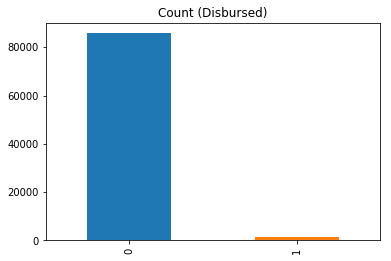

In [68]:
#data_s = data_for_ml.copy()
count_class_0, count_class_1 = data_s['Disbursed'].value_counts()
print('count_class_0: ', count_class_0, ', count_class_1: ', count_class_1)
data_s_class_0=data_s[data_s['Disbursed']==0]
data_s_class_1=data_s[data_s['Disbursed']==1]
data_s['Disbursed'].value_counts().plot(kind='bar', title='Count (Disbursed)')

In [69]:
count_class_1 / len(data_s) * 100

1.462882096069869

Wniosków zakończonych sukcesem jest znacznie mniej - poniżej 1,5 % - niezbalansowane dane

#### Under & Over Sampling

##### Przygotowanie do Under i Over Sampling

count_class_0:  60035 , count_class_1:  879


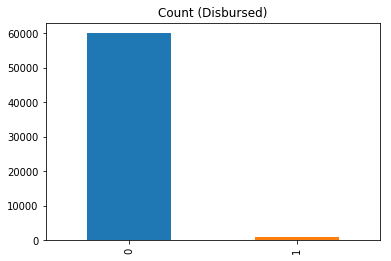

In [70]:
X_concat = pd.concat([X_train, y_train], axis=1)

count_class_0, count_class_1 = X_concat['Disbursed'].value_counts()
print('count_class_0: ', count_class_0, ', count_class_1: ', count_class_1)
data_s_class_0 = X_concat[X_concat['Disbursed']==0]
data_s_class_1 = X_concat[X_concat['Disbursed']==1]
X_concat['Disbursed'].value_counts().plot(kind='bar', title='Count (Disbursed)')

##### Under Sampling

1    879
0    879
Name: Disbursed, dtype: int64


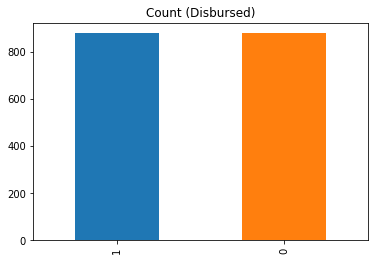

In [71]:
data_s_class_0_under = data_s_class_0.sample(count_class_1)
data_s_under = pd.concat([data_s_class_0_under,data_s_class_1],axis=0)
print(data_s_under['Disbursed'].value_counts())
data_s_under['Disbursed'].value_counts().plot(kind='bar', title='Count (Disbursed)')

In [72]:
X_train_under = data_s_under.drop(["Disbursed"], axis = 1)
y_train_under = data_s_under.Disbursed

In [73]:
pipe = Pipeline([("model",LogisticRegression())])
pipe.fit(X_train_under, y_train_under)

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [74]:
print('Accuracy Train:', accuracy_score(y_train_under, pipe.predict(X_train_under)))
print('Accuracy Test:', accuracy_score(y_test, pipe.predict(X_test)))
print('AUC Train: ', roc_auc_score(y_train_under, pipe.predict(X_train_under)))
print('AUC Test:', roc_auc_score(y_test, pipe.predict(X_test)))
print('F1 Train: ', f1_score(y_train_under, pipe.predict(X_train_under)))
print('F1 Test:', f1_score(y_test, pipe.predict(X_test)))
print('Suma predykcji:', pipe.predict(X_test).sum())

Accuracy Train: 0.7389078498293515
Accuracy Test: 0.6995709798513752
AUC Train:  0.7389078498293515
AUC Test: 0.6862866377744575
F1 Train:  0.7440044617958729
F1 Test: 0.06329869819658425
Suma predykcji: 7979


##### Over Sampling

1    60035
0    60035
Name: Disbursed, dtype: int64


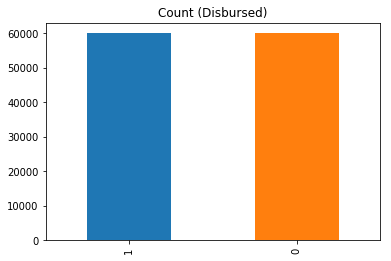

In [75]:
data_s_class_1_over = data_s_class_1.sample(count_class_0, replace=True) # z powtórzeniami, aby zwielokrotnić dane
data_s_over = pd.concat([data_s_class_0, data_s_class_1_over], axis=0)
print(data_s_over['Disbursed'].value_counts())
data_s_over['Disbursed'].value_counts().plot(kind='bar', title='Count (Disbursed)')

In [76]:
X_train_over = data_s_over.drop(["Disbursed"], axis = 1)
y_train_over = data_s_over.Disbursed

In [77]:
pipe = Pipeline([("model",LogisticRegression())])
pipe.fit(X_train_over, y_train_over)

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [78]:
print('Accuracy Train:', accuracy_score(y_train_over, pipe.predict(X_train_over)))
print('Accuracy Test:', accuracy_score(y_test, pipe.predict(X_test)))
print('AUC Train: ', roc_auc_score(y_train_over, pipe.predict(X_train_over)))
print('AUC Test:', roc_auc_score(y_test, pipe.predict(X_test)))
print('F1 Train: ', f1_score(y_train_over, pipe.predict(X_train_over)))
print('F1 Test:', f1_score(y_test, pipe.predict(X_test)))
print('Suma predykcji:', pipe.predict(X_test).sum())

Accuracy Train: 0.656400433080703
Accuracy Test: 0.7307898567379146
AUC Train:  0.6564004330807028
AUC Test: 0.614664013563755
F1 Train:  0.6259112835950817
F1 Test: 0.052574818010245356
Suma predykcji: 7024


### Zdefiniowanie automatycznego doboru parametrów do modeli

#### Zdefiniowanie funkcji do modelowania z określonymi parametrami

In [79]:
def modelowanie(X_train, y_train, X_test, y_test, names, models, parameters, scoring_p, models_run):
    best_names = []
    best_models = []
    best_params = []
    acc_test_tbl = []
    auc_test_tbl = []
    f1_test_tbl = []
    
    if len(names) != len(models) or len(models) != len(parameters) or len(models) != len(models_run):
        raise ValueError("Listy wejściowe nie są równej długości!", len(names), len(models), len(parameters) , len(models_run))
    
    for name, model, parameter, model_run in zip(names, models, parameters, models_run):
        if not model_run:
            continue
        print("Tunuję: ", name)
        pipe = Pipeline(model)
        gs = GridSearchCV(pipe, parameter, cv=10, scoring=scoring_p, n_jobs=-1)
        gs.fit(X_train, y_train)
    
        for mean, std, params in zip(gs.cv_results_["mean_test_score"], gs.cv_results_["std_test_score"], gs.cv_results_["params"]):
            print("mean: ", mean, ", std: ", std, params)
    
        best_names.append(name)
        best_models.append(gs.best_estimator_)
        best_params.append(gs.best_params_)        
    
    print()
    print("Wyniki na testowym:")

    for name, best_model, best_param in zip(best_names, best_models, best_params):
        acc_test_score = accuracy_score(y_test, best_model.predict(X_test))
        auc_test_score = roc_auc_score(y_test, best_model.predict(X_test))
        f1_test_score = f1_score(y_test, best_model.predict(X_test))
        print(name, " (", best_param, "):", acc_test_score, " :", auc_test_score, " :", f1_test_score)
        acc_test_tbl.append(acc_test_score)
        auc_test_tbl.append(auc_test_score)
        f1_test_tbl.append(f1_test_score)
    
    compare_dict = {'Method': best_names,
                    #'Best estimator': best_models,
                    #'Best params': best_params,
                    'Accuracy Score Test': acc_test_tbl,
                    'AUC Score test': auc_test_tbl,
                    'F1 Score test': f1_test_tbl           
                    }
    compare_df = pd.DataFrame(compare_dict)
    display(compare_df)

#### Przygotowanie parametrów

In [80]:
names = ["Regresja logistyczna", 
         "Regresja logistyczna - StandardScaler", 
         "Regresja logistyczna - MaxAbsScaler", 
         "Drzewo decyzyjne", 
         "Naiwny Bayes", 
         "BaggingClassifier",
         "RandomForest"
        ]

models = [
    [("model", LogisticRegression())],
    [("scaler", StandardScaler()), ("model", LogisticRegression())],
    [("scaler", MaxAbsScaler()), ("model", LogisticRegression())],
    [("model", DecisionTreeClassifier())],
    [("model", MultinomialNB())],
    [("model", BaggingClassifier())],
    [("model", RandomForestClassifier())]
]

models_run = [
    True, #LR
    True, #LR with StandardScaler
    True, #LR with MaxAbsScaler
    True, #DTC
    True, #MNB
    True, #BC
    True  #RF
]

LR_params = [
    {"model__C": [0.01, 1, 10, 100, 1000], "model__penalty": ["l1","l2"]}
]

parameters = [
    LR_params, 
    LR_params,
    LR_params,
    {"model__criterion":["gini","entropy"]},
    {},
    {"model__n_estimators": [10, 100, 1000], "model__max_samples": [0.5, 0.8 ,1], "model__max_features": [0.5,0.8, 1], "model__bootstrap": [False], "model__bootstrap_features": [False]},
    {"model__n_estimators": [10, 100, 1000], "model__max_depth": [10, 100, 1000], "model__min_samples_split": [2,4,8]}
]

#if len(names) != len(models) or len(models) != len(parameters) or len(models) != len(models_run):
#    raise ValueError("Listy wejściowe nie są równej długości!", len(names), len(models), len(parameters) , len(models_run))

#### Modelowanie dla under i over sampling

In [81]:
modelowanie(X_train_under, y_train_under, X_test, y_test, names, models, parameters, "roc_auc", models_run)

Tunuję:  Regresja logistyczna


C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


mean:  0.7914691816362994 , std:  0.02778593200163873 {'model__C': 0.01, 'model__penalty': 'l1'}
mean:  0.7699324657662896 , std:  0.041381047344006744 {'model__C': 0.01, 'model__penalty': 'l2'}
mean:  0.8289720198335003 , std:  0.021847690940839454 {'model__C': 1, 'model__penalty': 'l1'}
mean:  0.7702427357011329 , std:  0.04666631076018627 {'model__C': 1, 'model__penalty': 'l2'}
mean:  0.8248616861803869 , std:  0.024798532098065113 {'model__C': 10, 'model__penalty': 'l1'}
mean:  0.7702818166364124 , std:  0.04541680366694524 {'model__C': 10, 'model__penalty': 'l2'}
mean:  0.8242029569556932 , std:  0.025860506679075777 {'model__C': 100, 'model__penalty': 'l1'}
mean:  0.7621818098604023 , std:  0.040640524154908084 {'model__C': 100, 'model__penalty': 'l2'}
mean:  0.8244488845142017 , std:  0.02568389331966374 {'model__C': 1000, 'model__penalty': 'l1'}
mean:  0.7729119784404002 , std:  0.04068556066034783 {'model__C': 1000, 'model__penalty': 'l2'}
Tunuję:  Regresja logistyczna - Stand

C:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


mean:  0.7993480022063639 , std:  0.02726839041312405 {'model__C': 0.01, 'model__penalty': 'l1'}
mean:  0.8218002967179147 , std:  0.024279440588467417 {'model__C': 0.01, 'model__penalty': 'l2'}
mean:  0.824474443148681 , std:  0.02575119435621261 {'model__C': 1, 'model__penalty': 'l1'}
mean:  0.8243065288640198 , std:  0.025584760796788883 {'model__C': 1, 'model__penalty': 'l2'}
mean:  0.8242675965254523 , std:  0.02577839930826248 {'model__C': 10, 'model__penalty': 'l1'}
mean:  0.8243842449444426 , std:  0.02584025247530768 {'model__C': 10, 'model__penalty': 'l2'}
mean:  0.8243063802673077 , std:  0.025887139406800236 {'model__C': 100, 'model__penalty': 'l1'}
mean:  0.8242933037566438 , std:  0.025834168847154167 {'model__C': 100, 'model__penalty': 'l2'}
mean:  0.8242545200147883 , std:  0.02582887148065779 {'model__C': 1000, 'model__penalty': 'l1'}
mean:  0.824280375842692 , std:  0.025827497708612646 {'model__C': 1000, 'model__penalty': 'l2'}
Tunuję:  Regresja logistyczna - MaxAbsS

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


mean:  0.7593483677542757 , std:  0.03221296485029188 {'model__C': 0.01, 'model__penalty': 'l1'}
mean:  0.7825441659147672 , std:  0.019747377545833958 {'model__C': 0.01, 'model__penalty': 'l2'}
mean:  0.8272380448001255 , std:  0.022157297050763736 {'model__C': 1, 'model__penalty': 'l1'}
mean:  0.8213662457219006 , std:  0.022094410905350702 {'model__C': 1, 'model__penalty': 'l2'}
mean:  0.8249382134871132 , std:  0.02420300448503634 {'model__C': 10, 'model__penalty': 'l1'}
mean:  0.8252587365950906 , std:  0.023503846174444922 {'model__C': 10, 'model__penalty': 'l2'}
mean:  0.8244356594068258 , std:  0.025721760955202577 {'model__C': 100, 'model__penalty': 'l1'}
mean:  0.824603425094775 , std:  0.025135543269976975 {'model__C': 100, 'model__penalty': 'l2'}
mean:  0.8243451640091631 , std:  0.02583942354310752 {'model__C': 1000, 'model__penalty': 'l1'}
mean:  0.8244098035789221 , std:  0.025770110773252555 {'model__C': 1000, 'model__penalty': 'l2'}
Tunuję:  Drzewo decyzyjne
mean:  0.6

C:\Anaconda\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Anaconda\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Anaconda\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Regresja logistyczna - MaxAbsScaler  ( {'model__C': 1, 'model__penalty': 'l1'} ): 0.740710947674864  : 0.7321636147691414  : 0.07766725711949857
Drzewo decyzyjne  ( {'model__criterion': 'gini'} ): 0.7055466176357925  : 0.676824347161372  : 0.06221788459192387
Naiwny Bayes  ( {} ): 0.63835899793151  : 0.5964809534113128  : 0.04414295838817455
BaggingClassifier  ( {'model__bootstrap': False, 'model__bootstrap_features': False, 'model__max_features': 0.5, 'model__max_samples': 0.5, 'model__n_estimators': 1000} ): 0.7122883628284685  : 0.7527230564882698  : 0.07693253041661548
RandomForest  ( {'model__max_depth': 1000, 'model__min_samples_split': 8, 'model__n_estimators': 1000} ): 0.7102581781965832  : 0.755441177399638  : 0.07711078574914593


,Method,Accuracy Score Test,AUC Score test,F1 Score test
0,Regresja logistyczna,0.745308,0.734497,0.078958
1,Regresja logistyczna - StandardScaler,0.745959,0.731079,0.078377
2,Regresja logistyczna - MaxAbsScaler,0.740711,0.732164,0.077667
3,Drzewo decyzyjne,0.705547,0.676824,0.062218
4,Naiwny Bayes,0.638359,0.596481,0.044143
5,BaggingClassifier,0.712288,0.752723,0.076933
6,RandomForest,0.710258,0.755441,0.077111


In [82]:
modelowanie(X_train_over, y_train_over, X_test, y_test, names, models, parameters, "roc_auc", models_run)

Tunuję:  Regresja logistyczna


C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


mean:  0.8379275310280054 , std:  0.005467318368183224 {'model__C': 0.01, 'model__penalty': 'l1'}
mean:  0.7507334531816678 , std:  0.050960429476385766 {'model__C': 0.01, 'model__penalty': 'l2'}
mean:  0.8425247381295524 , std:  0.005147742506569918 {'model__C': 1, 'model__penalty': 'l1'}
mean:  0.751233097631921 , std:  0.054603454132264674 {'model__C': 1, 'model__penalty': 'l2'}
mean:  0.8425018620839786 , std:  0.005151434845866373 {'model__C': 10, 'model__penalty': 'l1'}
mean:  0.7597839019933381 , std:  0.044973954808338386 {'model__C': 10, 'model__penalty': 'l2'}
mean:  0.842490796543692 , std:  0.0051482651281267 {'model__C': 100, 'model__penalty': 'l1'}
mean:  0.739903382884504 , std:  0.052557668311450215 {'model__C': 100, 'model__penalty': 'l2'}
mean:  0.8424902132890529 , std:  0.00514001929213015 {'model__C': 1000, 'model__penalty': 'l1'}
mean:  0.7570991303690406 , std:  0.049589541906196216 {'model__C': 1000, 'model__penalty': 'l2'}
Tunuję:  Regresja logistyczna - Standa

C:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


mean:  0.8422978348690608 , std:  0.005225209781574167 {'model__C': 0.01, 'model__penalty': 'l1'}
mean:  0.842333083122946 , std:  0.005131049205277774 {'model__C': 0.01, 'model__penalty': 'l2'}
mean:  0.84250658470257 , std:  0.00513128579160123 {'model__C': 1, 'model__penalty': 'l1'}
mean:  0.8425021368916753 , std:  0.005129198528491886 {'model__C': 1, 'model__penalty': 'l2'}
mean:  0.8425008411651405 , std:  0.00512918305976448 {'model__C': 10, 'model__penalty': 'l1'}
mean:  0.8424998477509189 , std:  0.005129207378734205 {'model__C': 10, 'model__penalty': 'l2'}
mean:  0.8425007689647125 , std:  0.005129812082793857 {'model__C': 100, 'model__penalty': 'l1'}
mean:  0.8424998061409084 , std:  0.005129358801488197 {'model__C': 100, 'model__penalty': 'l2'}
mean:  0.8425010075857725 , std:  0.005129453128992654 {'model__C': 1000, 'model__penalty': 'l1'}
mean:  0.8424997256697774 , std:  0.0051293840941094 {'model__C': 1000, 'model__penalty': 'l2'}
Tunuję:  Regresja logistyczna - MaxAbsS

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


mean:  0.8225115052818903 , std:  0.005587503164099172 {'model__C': 0.01, 'model__penalty': 'l1'}
mean:  0.8244572849140273 , std:  0.005174998135831394 {'model__C': 0.01, 'model__penalty': 'l2'}
mean:  0.8419965139450388 , std:  0.005118052592073445 {'model__C': 1, 'model__penalty': 'l1'}
mean:  0.8290174170482532 , std:  0.0051771625083718775 {'model__C': 1, 'model__penalty': 'l2'}
mean:  0.8425168079228635 , std:  0.00513384746011895 {'model__C': 10, 'model__penalty': 'l1'}
mean:  0.8327650015717334 , std:  0.004795034544792591 {'model__C': 10, 'model__penalty': 'l2'}
mean:  0.8425035436534156 , std:  0.0051292657926037015 {'model__C': 100, 'model__penalty': 'l1'}
mean:  0.8399568286206377 , std:  0.004909254949633861 {'model__C': 100, 'model__penalty': 'l2'}
mean:  0.8425009937890975 , std:  0.0051312812616899975 {'model__C': 1000, 'model__penalty': 'l1'}
mean:  0.8423282624542825 , std:  0.005118116927507183 {'model__C': 1000, 'model__penalty': 'l2'}
Tunuję:  Drzewo decyzyjne
mean

C:\Anaconda\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Anaconda\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Anaconda\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Regresja logistyczna - StandardScaler  ( {'model__C': 1, 'model__penalty': 'l1'} ): 0.7538496897264997  : 0.7400832414657952  : 0.08173763932552158
Regresja logistyczna - MaxAbsScaler  ( {'model__C': 10, 'model__penalty': 'l1'} ): 0.7536964682448479  : 0.7375062780538192  : 0.08116604744212633
Drzewo decyzyjne  ( {'model__criterion': 'gini'} ): 0.9693557036696545  : 0.5220949984048215  : 0.05660377358490566
Naiwny Bayes  ( {} ): 0.578717536198575  : 0.5412114748609352  : 0.03475513428120063
BaggingClassifier  ( {'model__bootstrap': False, 'model__bootstrap_features': False, 'model__max_features': 0.5, 'model__max_samples': 0.8, 'model__n_estimators': 10} ): 0.9842181873898721  : 0.500899558246125  : 0.004830917874396135
RandomForest  ( {'model__max_depth': 1000, 'model__min_samples_split': 2, 'model__n_estimators': 1000} ): 0.9841415766490462  : 0.5008606659001387  : 0.004807692307692307


,Method,Accuracy Score Test,AUC Score test,F1 Score test
0,Regresja logistyczna,0.753582,0.738698,0.081394
1,Regresja logistyczna - StandardScaler,0.753850,0.740083,0.081738
2,Regresja logistyczna - MaxAbsScaler,0.753696,0.737506,0.081166
3,Drzewo decyzyjne,0.969356,0.522095,0.056604
4,Naiwny Bayes,0.578718,0.541211,0.034755
5,BaggingClassifier,0.984218,0.500900,0.004831
6,RandomForest,0.984142,0.500861,0.004808
